In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

In [38]:
gift_df = pd.read_excel('/content/ASU Gift Record 20250106 ANONYMIZED.xlsx')
constituent_df = pd.read_excel('/content/ASU Constituent Records 20250106 ANONYMIZED.xlsx')
rfm_df = pd.read_excel('/content/RFM Score Computation.xlsx')

In [39]:
# Merge
rfm_merge = rfm_df.merge(constituent_df, left_on='Donor ID', right_on='Constituent ID', how='left')

In [49]:
# Rename the ID field to match gift_df
constituent_df = constituent_df.rename(columns={"Constituent ID": "ConstituentLookupId"})

# Add year
gift_df["Year"] = pd.to_datetime(gift_df["Date"], errors="coerce").dt.year
gift_recent = gift_df[gift_df["Year"].between(2020, 2024)]

# Merge corrected
merged = gift_recent.merge(constituent_df, on='ConstituentLookupId', how='left')

# Aggregate donation amount by City
city_donation = merged.groupby('City')["Amount"].sum().reset_index().sort_values(by='Amount', ascending=False)

# Select Top 10
top10_cities = city_donation.head(10)

Top 10 Cities by Total Donation (2020–2024)

<ipython-input-50-534aa73f17f4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_cities['Amount_K'] = top10_cities['Amount'] / 1e3


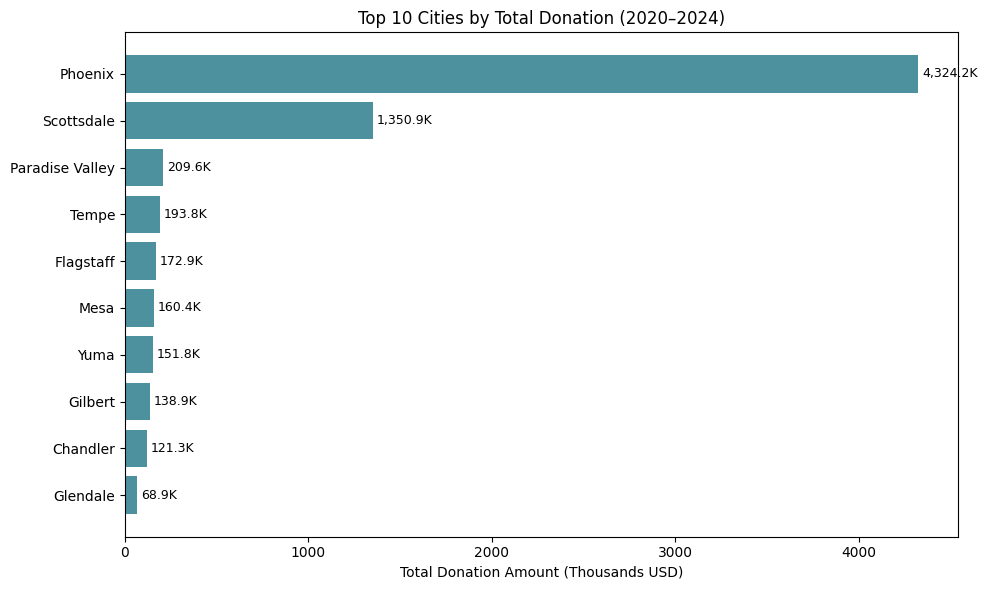

In [50]:
# Load & clean IDs
constituent_df = constituent_df.rename(columns={"Constituent ID": "ConstituentLookupId"})
gift_df["Year"] = pd.to_datetime(gift_df["Date"], errors="coerce").dt.year
gift_recent = gift_df[gift_df["Year"].between(2020, 2024)]

# Merge donation with city info
merged = gift_recent.merge(constituent_df, on='ConstituentLookupId', how='left')

# Aggregate donation by city
city_donation = merged.groupby('City')["Amount"].sum().reset_index().sort_values(by='Amount', ascending=False)
top10_cities = city_donation.head(10)
top10_cities['Amount_K'] = top10_cities['Amount'] / 1e3

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(top10_cities['City'], top10_cities['Amount_K'], color='#4C919D')
plt.xlabel('Total Donation Amount (Thousands USD)')
plt.title('Top 10 Cities by Total Donation (2020–2024)')
for bar in bars:
    width = bar.get_width()
    plt.text(width + 20, bar.get_y() + bar.get_height()/2, f'{width:,.1f}K', va='center', fontsize=9)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Donor Segment Distribution in Top 10 Cities

<ipython-input-53-8668e8af0ef0>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(bottoms[i] + val/2, i, f'{pct:.1f}%', va='center', ha='center', fontsize=7)
<ipython-input-53-8668e8af0ef0>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(bottoms[i] + val/2, i, f'{pct:.1f}%', va='center', ha='center', fontsize=7)
<ipython-input-53-8668e8af0ef0>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(bottoms[i] 

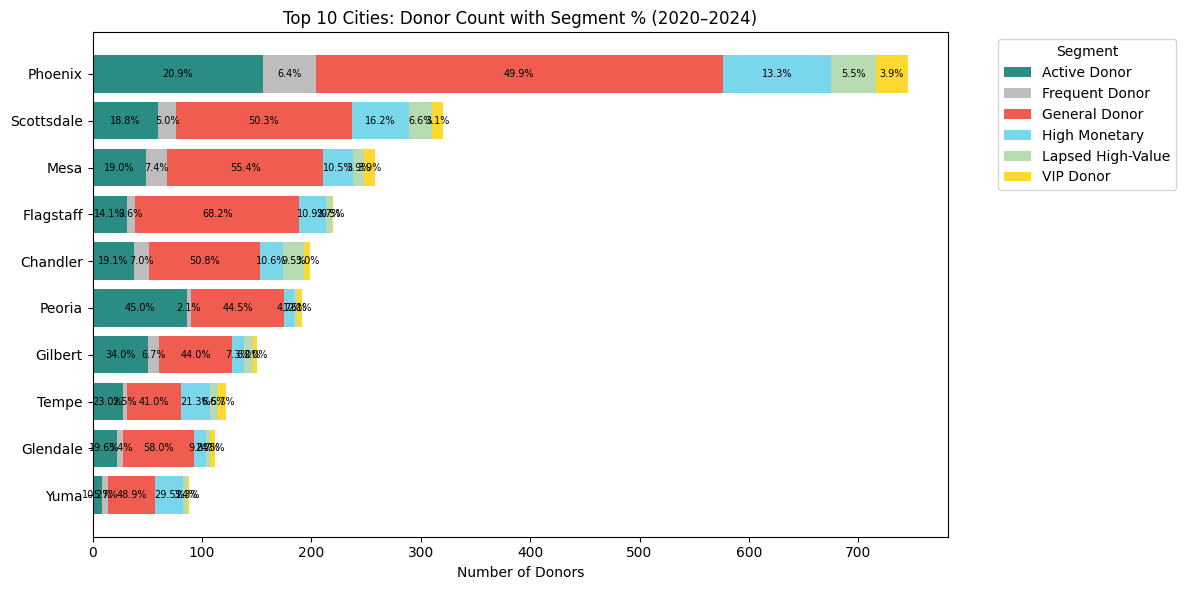

In [53]:
# Harmonize RFM ID column
rfm_df = rfm_df.rename(columns={"Donor ID": "ConstituentLookupId"})
rfm_df["Year"] = rfm_df["Year"].astype(int)
rfm_recent = rfm_df[rfm_df["Year"].between(2020, 2024)].copy()
rfm_merge_recent = rfm_recent.merge(constituent_df, on='ConstituentLookupId', how='left')

# Group by city and segment
city_seg_counts = rfm_merge_recent.groupby(['City', 'Segment'])['ConstituentLookupId'].nunique().reset_index()
city_seg_counts.columns = ['City', 'Segment', 'Count']

# Select top 10 cities
top10_cities = city_seg_counts.groupby('City')['Count'].sum().sort_values(ascending=False).head(10).index
city_seg_counts = city_seg_counts[city_seg_counts['City'].isin(top10_cities)]

# Pivot
pivot_df = city_seg_counts.pivot(index='City', columns='Segment', values='Count').fillna(0)
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='Total', ascending=True).drop(columns='Total')
pivot_pct = pivot_df.divide(pivot_df.sum(axis=1), axis=0) * 100

# Color map
colors = {
    'Active Donor': '#2B8C83',
    'Frequent Donor': '#BDBDBD',
    'General Donor': '#F05D50',
    'High Monetary': '#7AD6EB',
    'Lapsed High-Value': '#B7DBB1',
    'VIP Donor': '#FFD92F'
}

# Plot
plt.figure(figsize=(12, 6))
bottoms = pd.Series([0]*len(pivot_df), index=pivot_df.index)
for segment in pivot_df.columns:
    values = pivot_df[segment]
    bars = plt.barh(pivot_df.index, values, left=bottoms, color=colors.get(segment, '#ccc'), label=segment)
    for i, (val, pct) in enumerate(zip(values, pivot_pct[segment])):
        if val > 0:
            plt.text(bottoms[i] + val/2, i, f'{pct:.1f}%', va='center', ha='center', fontsize=7)
    bottoms += values
plt.xlabel('Number of Donors')
plt.title('Top 10 Cities: Donor Count with Segment % (2020–2024)')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

Top 20% Donor Contribution by City

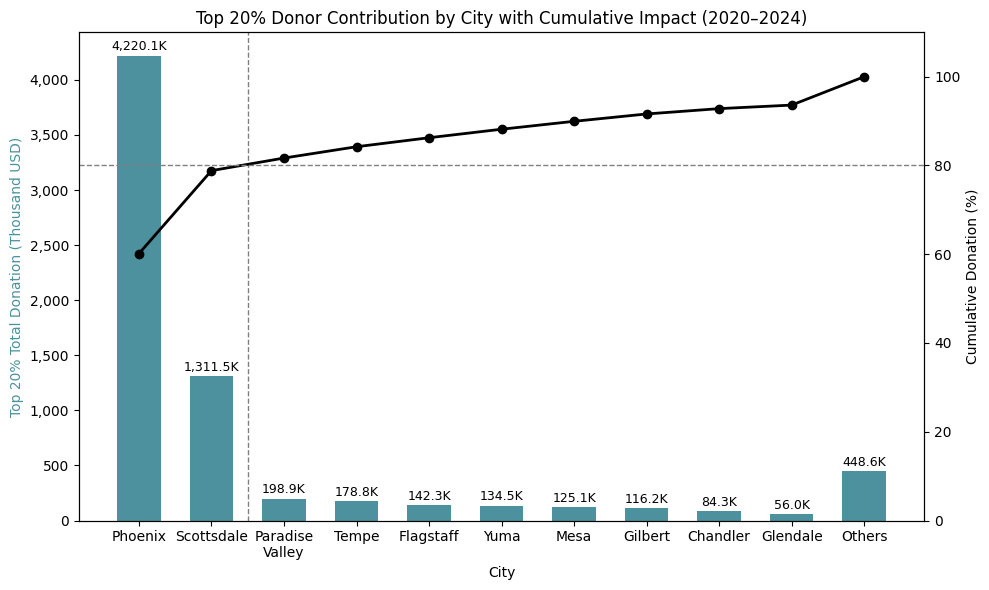

In [55]:
# Get top 20% donors
top20 = gift_recent.groupby("ConstituentLookupId")["Amount"].sum().nlargest(
    int(len(gift_recent["ConstituentLookupId"].unique()) * 0.2)
).index
top20_df = gift_recent[gift_recent["ConstituentLookupId"].isin(top20)]
top20_merged = top20_df.merge(constituent_df, on="ConstituentLookupId", how="left")
top20_city = top20_merged.groupby("City")["Amount"].sum().reset_index().rename(columns={"Amount": "Top20_Total_Donation"})
top20_city_sorted = top20_city.sort_values(by="Top20_Total_Donation", ascending=False)

# Cumulative impact
top_n = 10
top_cities = top20_city_sorted.head(top_n)
others = pd.DataFrame({
    'City': ['Others'],
    'Top20_Total_Donation': [top20_city_sorted['Top20_Total_Donation'][top_n:].sum()]
})
final_data = pd.concat([top_cities, others]).reset_index(drop=True)
final_data['Cumulative_Donation'] = final_data['Top20_Total_Donation'].cumsum()
final_data['Cumulative_Percentage'] = final_data['Cumulative_Donation'] / final_data['Top20_Total_Donation'].sum() * 100
final_data['City'] = final_data['City'].str.replace(' ', '\n')
x = np.arange(len(final_data['City']))

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))
bars = ax1.bar(x, final_data['Top20_Total_Donation'] / 1e3, width=0.6, color='#4C919D')
ax1.set_ylabel('Top 20% Total Donation (Thousand USD)', color='#4C919D')
ax1.set_xlabel('City')
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
ax1.yaxis.set_major_formatter(formatter)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 20, f'{height:,.1f}K', ha='center', va='bottom', fontsize=9)
ax2 = ax1.twinx()
ax2.plot(x, final_data['Cumulative_Percentage'], color='black', marker='o', linewidth=2)
ax2.set_ylabel('Cumulative Donation (%)', color='black')
ax2.set_ylim(0, 110)
ax2.axhline(80, color='gray', linestyle='--', linewidth=1)
ax1.axvline(x=1.5, color='gray', linestyle='--', linewidth=1)
plt.xticks(x, final_data['City'], fontsize=10)
plt.title('Top 20% Donor Contribution by City with Cumulative Impact (2020–2024)')
plt.tight_layout()
plt.show()

Top 10 Cities by VIP Donor Count

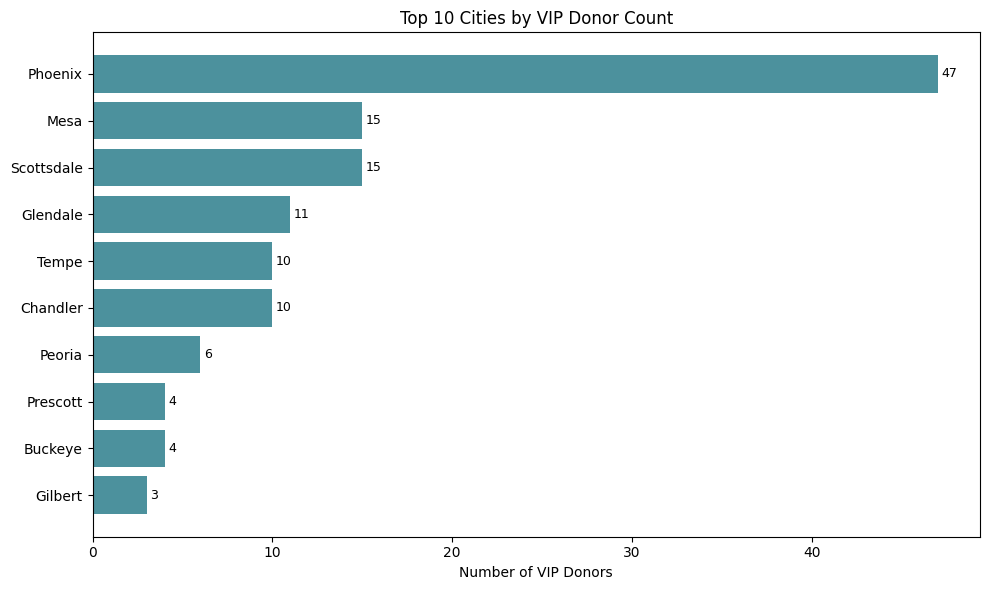

In [56]:
# Count VIP donors per city
vip_city_count = rfm_merge[rfm_merge['Segment'] == 'VIP Donor'].groupby('City').size().reset_index(name='VIP_Donor_Count')
vip_city_top = vip_city_count.sort_values(by='VIP_Donor_Count', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(vip_city_top['City'], vip_city_top['VIP_Donor_Count'], color='#4C919D')
plt.xlabel('Number of VIP Donors')
plt.title('Top 10 Cities by VIP Donor Count')
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.2, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center', fontsize=9)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()